In [1]:
import findspark

In [2]:
findspark.add_jars('/app/postgresql-42.1.4.jar')
findspark.init()

In [3]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("Stocks:ETL")
    .config("spark.driver.memory", "512m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

In [4]:
from pathlib import Path
import pandas as pd

In [5]:
import numpy as np

In [6]:
#ds = spark.read.csv('/dataset/BankChurners.csv', header=True)

In [7]:
#ds.printSchema()
#ds.count()

In [8]:
ds.show(22)

NameError: name 'ds' is not defined

In [9]:
ds.select('Attrition_Flag').groupby('Attrition_Flag').count().show()

NameError: name 'ds' is not defined

In [10]:
ds = spark.read.option("header", True).option("inferSchema", True).csv('/dataset/BankChurners.csv')

In [11]:
ds.printSchema()

root
 |-- CLIENTNUM: integer (nullable = true)
 |-- Attrition_Flag: string (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (n

In [12]:
import pyspark.sql.types as t

In [13]:
import pyspark.sql.functions as f

In [15]:
#dataset_schema = t.StructType([
      t.StructField('CLIENTNUM', t.DoubleType(), True)
    , t.StructField('Attrition_Flag', t.StringType(), True)
    , t.StructField('Customer_Age', t.IntegerType(), True)
    , t.StructField('Gender', t.StringType(), True)
    , t.StructField('Dependent_count', t.IntegerType(), True)
    , t.StructField('Education_Level', t.StringType(), True)
    , t.StructField('Marital_Status', t.StringType(), True)
    , t.StructField('Income_Category', t.StringType(), True)
    , t.StructField('Card_Category', t.StringType(), True)
    , t.StructField('Months_on_book', t.IntegerType(), True)
    , t.StructField('Total_Relationship_Count', t.IntegerType(), True)
    , t.StructField('Months_Inactive_12_mon', t.IntegerType(), True)
    , t.StructField('Contacts_Count_12_mon', t.IntegerType(), True)
    , t.StructField('Credit_Limit', t.IntegerType(), True)
    , t.StructField('Total_Revolving_Bal', t.IntegerType(), True)
    , t.StructField('Avg_Open_To_Buy', t.IntegerType(), True)
    , t.StructField('Total_Amt_Chng_Q4_Q1', t.DoubleType(), True)
    , t.StructField('Total_Trans_Amt', t.IntegerType(), True)
    , t.StructField('Total_Trans_Ct', t.IntegerType(), True)
    , t.StructField('Total_Ct_Chng_Q4_Q1', t.DoubleType(), True)
    , t.StructField('Avg_Utilization_Ratio', t.DoubleType(), True)
    , t.StructField('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', t.DoubleType(), True)
    , t.StructField('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', t.DoubleType(), True)
])

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 3)

In [16]:
#ds = spark.read.csv('/dataset/BankChurners.csv', header=True, schema=dataset_schema)
#ds.printSchema()

In [17]:
ds=ds.drop('CLIENTNUM')

In [18]:
ds=ds.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1')

In [19]:
ds=ds.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2')

In [20]:
from pyspark.sql.functions import col,when

In [21]:
ds = ds.withColumn("Educaton_Level", when(ds.Education_Level == "Unknown",None).otherwise(ds.Education_Level))

In [22]:
ds = ds.withColumn("Marital_Status", when(ds.Marital_Status == "Unknown",None).otherwise(ds.Marital_Status))

In [23]:
ds = ds.withColumn("Income_Category", when(ds.Income_Category == "Unknown",None).otherwise(ds.Income_Category))

In [24]:
#ds = ds.filter(f.col('Attrition_Flag').isNotNull())

In [25]:
ds.show(22)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+--------------+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Educaton_Level|
+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------

In [26]:
from pyspark.sql.functions import *
ds = ds.withColumn('Attrition_Flag', regexp_replace('Attrition_Flag', 'Existing Customer', '0'))
ds = ds.withColumn('Attrition_Flag', regexp_replace('Attrition_Flag', 'Attrited Customer', '1'))


In [27]:
from pyspark.sql.types import DoubleType, IntegerType
ds = ds.withColumn('Attrition_Flag', ds['Attrition_Flag'].cast(IntegerType()))

In [28]:
ds.printSchema()

root
 |-- Attrition_Flag: integer (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (nullable = true)
 |-- Educaton_Level: stri

In [29]:
ds.groupBy('Attrition_Flag').count().orderBy('count').show()

+--------------+-----+
|Attrition_Flag|count|
+--------------+-----+
|             1| 1627|
|             0| 8500|
+--------------+-----+



In [30]:
churned = ds.filter(f.col('Attrition_Flag') == 1).count()
total = ds.count()
churned / total

0.1606596227905599

In [31]:
# Cálculo de proporcion de nulos para eliminar las columnas con mas del 50%

In [32]:
ds_nulos = ds.select([f.sum(f.col(c).isNull().cast('integer') / ds.count()).alias(c) for c in ds.columns])

In [33]:
ds_nulos.show()

+--------------+------------+------+---------------+---------------+-------------------+-------------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------------------+
|Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|     Marital_Status|    Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|    Educaton_Level|
+--------------+------------+------+---------------+---------------+-------------------+-------------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+----

In [34]:
def _drop_nulos(ds, max_nulo_prop=0.5):
    ds_nulos = ds.select([f.sum(f.col(c).isNull().cast('integer') / ds.count()).alias(c) 
                          for c in ds.columns])
    null_cols = [c for c in ds_nulos.columns if ds_nulos.select(c).first()[0] > max_nulo_prop 
                 and c not in PROTECTED_COLS]
    ds = ds.drop(*null_cols)
    return ds

In [35]:
from pyspark.sql.functions import rand, when
ds = ds.withColumn('train', when(rand(seed=3618) > 0.2, True).otherwise(False))

In [36]:
ds.select('train').groupby('train').count().show()

+-----+-----+
|train|count|
+-----+-----+
| true| 8157|
|false| 1970|
+-----+-----+



In [37]:
ds.printSchema()

root
 |-- Attrition_Flag: integer (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (nullable = true)
 |-- Educaton_Level: stri

In [38]:
PROTECTED_COLS = ['Attrition_Flag', 'train']
ds = _drop_nulos(ds)

In [39]:
ds.dtypes

[('Attrition_Flag', 'int'),
 ('Customer_Age', 'int'),
 ('Gender', 'string'),
 ('Dependent_count', 'int'),
 ('Education_Level', 'string'),
 ('Marital_Status', 'string'),
 ('Income_Category', 'string'),
 ('Card_Category', 'string'),
 ('Months_on_book', 'int'),
 ('Total_Relationship_Count', 'int'),
 ('Months_Inactive_12_mon', 'int'),
 ('Contacts_Count_12_mon', 'int'),
 ('Credit_Limit', 'double'),
 ('Total_Revolving_Bal', 'int'),
 ('Avg_Open_To_Buy', 'double'),
 ('Total_Amt_Chng_Q4_Q1', 'double'),
 ('Total_Trans_Amt', 'int'),
 ('Total_Trans_Ct', 'int'),
 ('Total_Ct_Chng_Q4_Q1', 'double'),
 ('Avg_Utilization_Ratio', 'double'),
 ('Educaton_Level', 'string'),
 ('train', 'boolean')]

In [40]:
type(ds)

pyspark.sql.dataframe.DataFrame

In [41]:
def _drop_std(ds, min_std_dev=1.5e-2):
    num_cols = [c for c,dtype in ds.dtypes if dtype.startswith(('int', 'double'))]
    ds_std = ds.select([f.stddev(f.col(c)).alias(c) for c in num_cols])
    low_variance_cols = [c for c in ds_std.columns if ds_std.select(c).first()[0] < min_std_dev 
                         and c not in PROTECTED_COLS]
    ds.drop(*low_variance_cols)
    return ds

In [42]:
ds = _drop_std(ds)

In [43]:
def _get_typed_cols(ds, col_type='cat'):
    assert col_type in ('cat', 'num')
    dtypes = ('int', 'double') if col_type == 'num' else ('string')
    typed_cols = [c for c,dtype in ds.dtypes if dtype.startswith(dtypes) 
                  and c not in PROTECTED_COLS]
    return typed_cols

In [44]:
num_cols = _get_typed_cols(ds, col_type='num')
cat_cols = _get_typed_cols(ds, col_type='cat')
num_cols, cat_cols

(['Customer_Age',
  'Dependent_count',
  'Months_on_book',
  'Total_Relationship_Count',
  'Months_Inactive_12_mon',
  'Contacts_Count_12_mon',
  'Credit_Limit',
  'Total_Revolving_Bal',
  'Avg_Open_To_Buy',
  'Total_Amt_Chng_Q4_Q1',
  'Total_Trans_Amt',
  'Total_Trans_Ct',
  'Total_Ct_Chng_Q4_Q1',
  'Avg_Utilization_Ratio'],
 ['Gender',
  'Education_Level',
  'Marital_Status',
  'Income_Category',
  'Card_Category',
  'Educaton_Level'])

In [45]:
val_counts = ds.filter(f.col('Education_Level').isNotNull()).select('Education_Level').groupBy('Education_Level').count().orderBy(f.desc('count'))
val_counts.show()

+---------------+-----+
|Education_Level|count|
+---------------+-----+
|       Graduate| 3128|
|    High School| 2013|
|        Unknown| 1519|
|     Uneducated| 1487|
|        College| 1013|
|  Post-Graduate|  516|
|      Doctorate|  451|
+---------------+-----+



In [46]:
val_counts.select('Education_Level').first()[0]

'Graduate'

In [47]:
def _fill_nulls(ds):
    for t in ['num', 'cat']:
        cols = _get_typed_cols(ds, col_type=t)
        for c in cols:
            if t == 'num':
                median_val = ds.approxQuantile(c, [0.5], 0)[0]
                ds = ds.fillna(median_val, subset=[c])
            else:
                val_counts = ds.filter(f.col(c).isNotNull()).select(c).groupBy(c).count().orderBy(f.desc('count'))
                common_val = val_counts.select(c).first()[0]
                ds = ds.fillna(common_val, subset=[c])
    return ds

In [48]:
ds.select('Education_Level').groupBy('Education_Level').count().orderBy(f.desc('Education_Level')).show()

+---------------+-----+
|Education_Level|count|
+---------------+-----+
|        Unknown| 1519|
|     Uneducated| 1487|
|  Post-Graduate|  516|
|    High School| 2013|
|       Graduate| 3128|
|      Doctorate|  451|
|        College| 1013|
+---------------+-----+



In [49]:
ds = _fill_nulls(ds)

In [50]:
import seaborn as sns

In [51]:
Months_on_book_mean = ds.select(f.mean(f.col('Months_on_book'))).first()[0]

In [52]:
Months_on_book_mean

35.928409203120374

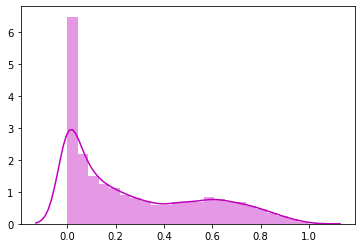

In [53]:
g = sns.distplot(ds.select('Avg_Utilization_Ratio').toPandas(), color='m')

No handles with labels found to put in legend.


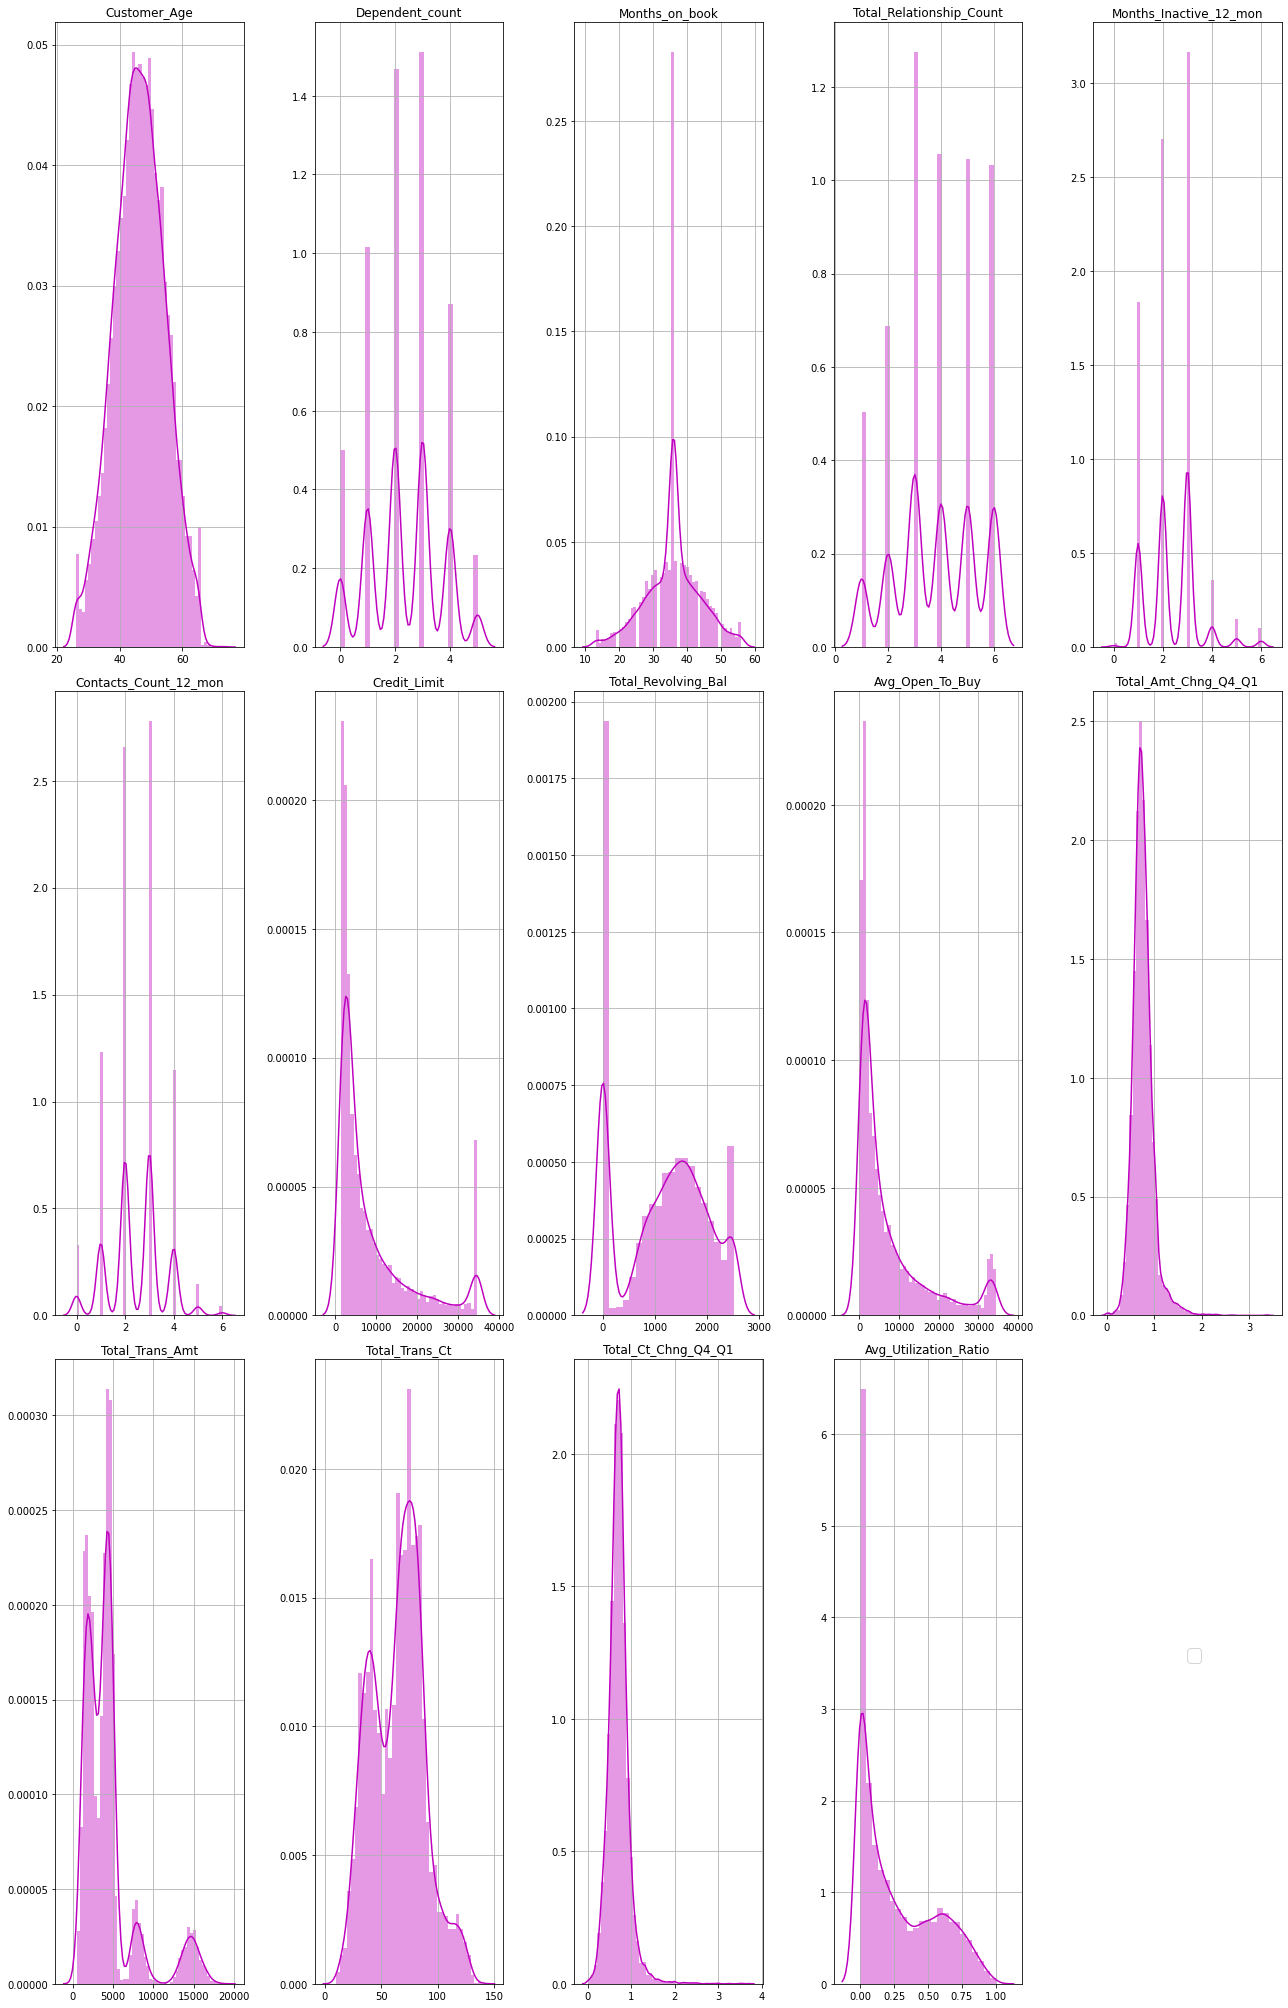

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize = (18,28))
nrow = 3
ncol = 5
i = 1
for c in num_cols:
    plt.subplot(nrow, ncol, i)
    plt.grid()
    plt.title(c) 
    sns.distplot(ds.select(c).toPandas(), color='m')
    i += 1
plt.tight_layout()
plt.legend(loc=4, bbox_to_anchor=(2.0, 0.5), prop={'size': 18})
plt.show()

In [55]:
@f.udf('double')
def np_log(x):
    if x is None:
        return 0
    return float(np.log(x + 1)) 

In [56]:
ds = ds.withColumn('log_Credit_Limit', np_log(ds.Credit_Limit))
ds = ds.drop('Credit_Limit')

In [57]:
ds = ds.withColumn('log_Avg_Open_To_Buy', np_log(ds.Avg_Open_To_Buy))
ds = ds.drop('Avg_Open_To_Buy')

In [58]:
ds = ds.withColumn('log_Total_Trans_Amt', np_log(ds.Total_Trans_Amt))
ds = ds.drop('Total_Trans_Amt')

In [59]:
ds = ds.withColumn('log_Total_Ct_Chng_Q4_Q1', np_log(ds.Total_Ct_Chng_Q4_Q1))
ds = ds.drop('Total_Ct_Chng_Q4_Q1')

In [60]:
ds = ds.withColumn('log_Avg_Utilization_Ratio', np_log(ds.Avg_Utilization_Ratio))
ds = ds.drop('Avg_Utilization_Ratio')

In [61]:
ds.dtypes

[('Attrition_Flag', 'int'),
 ('Customer_Age', 'int'),
 ('Gender', 'string'),
 ('Dependent_count', 'int'),
 ('Education_Level', 'string'),
 ('Marital_Status', 'string'),
 ('Income_Category', 'string'),
 ('Card_Category', 'string'),
 ('Months_on_book', 'int'),
 ('Total_Relationship_Count', 'int'),
 ('Months_Inactive_12_mon', 'int'),
 ('Contacts_Count_12_mon', 'int'),
 ('Total_Revolving_Bal', 'int'),
 ('Total_Amt_Chng_Q4_Q1', 'double'),
 ('Total_Trans_Ct', 'int'),
 ('Educaton_Level', 'string'),
 ('train', 'boolean'),
 ('log_Credit_Limit', 'double'),
 ('log_Avg_Open_To_Buy', 'double'),
 ('log_Total_Trans_Amt', 'double'),
 ('log_Total_Ct_Chng_Q4_Q1', 'double'),
 ('log_Avg_Utilization_Ratio', 'double')]

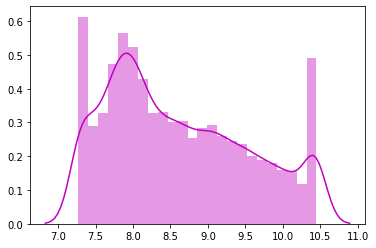

In [62]:
g = sns.distplot(ds.select('log_Credit_Limit').toPandas(), color='m')

In [63]:
# Salvándolo a Postgres

In [64]:
ds \
    .write \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres/workshop") \
    .option("dbtable", "workshop.churn") \
    .option("user", "workshop") \
    .option("password", "w0rkzh0p") \
    .option("driver", "org.postgresql.Driver") \
    .mode('overwrite') \
    .save()

In [65]:
num_cols = _get_typed_cols(ds, col_type='num')
cat_cols = _get_typed_cols(ds, col_type='cat')
ds.columns, cat_cols, num_cols

(['Attrition_Flag',
  'Customer_Age',
  'Gender',
  'Dependent_count',
  'Education_Level',
  'Marital_Status',
  'Income_Category',
  'Card_Category',
  'Months_on_book',
  'Total_Relationship_Count',
  'Months_Inactive_12_mon',
  'Contacts_Count_12_mon',
  'Total_Revolving_Bal',
  'Total_Amt_Chng_Q4_Q1',
  'Total_Trans_Ct',
  'Educaton_Level',
  'train',
  'log_Credit_Limit',
  'log_Avg_Open_To_Buy',
  'log_Total_Trans_Amt',
  'log_Total_Ct_Chng_Q4_Q1',
  'log_Avg_Utilization_Ratio'],
 ['Gender',
  'Education_Level',
  'Marital_Status',
  'Income_Category',
  'Card_Category',
  'Educaton_Level'],
 ['Customer_Age',
  'Dependent_count',
  'Months_on_book',
  'Total_Relationship_Count',
  'Months_Inactive_12_mon',
  'Contacts_Count_12_mon',
  'Total_Revolving_Bal',
  'Total_Amt_Chng_Q4_Q1',
  'Total_Trans_Ct',
  'log_Credit_Limit',
  'log_Avg_Open_To_Buy',
  'log_Total_Trans_Amt',
  'log_Total_Ct_Chng_Q4_Q1',
  'log_Avg_Utilization_Ratio'])

In [66]:
from pyspark.ml.feature import StringIndexer

def _encode_categorical(ds):
    cat_cols = _get_typed_cols(ds, col_type='cat')
    encoded_cols = []
    for cat in cat_cols:
        cat_suff = f'{cat}_num'
        encoded_cols.append(cat_suff)
        if cat_suff not in ds.columns:
            indexer = StringIndexer(inputCol=cat, outputCol=cat_suff).fit(ds)
            ds = indexer.transform(ds)
    return ds, encoded_cols

In [67]:
ds, encoded_cols = _encode_categorical(ds)

In [68]:
ds.dtypes

[('Attrition_Flag', 'int'),
 ('Customer_Age', 'int'),
 ('Gender', 'string'),
 ('Dependent_count', 'int'),
 ('Education_Level', 'string'),
 ('Marital_Status', 'string'),
 ('Income_Category', 'string'),
 ('Card_Category', 'string'),
 ('Months_on_book', 'int'),
 ('Total_Relationship_Count', 'int'),
 ('Months_Inactive_12_mon', 'int'),
 ('Contacts_Count_12_mon', 'int'),
 ('Total_Revolving_Bal', 'int'),
 ('Total_Amt_Chng_Q4_Q1', 'double'),
 ('Total_Trans_Ct', 'int'),
 ('Educaton_Level', 'string'),
 ('train', 'boolean'),
 ('log_Credit_Limit', 'double'),
 ('log_Avg_Open_To_Buy', 'double'),
 ('log_Total_Trans_Amt', 'double'),
 ('log_Total_Ct_Chng_Q4_Q1', 'double'),
 ('log_Avg_Utilization_Ratio', 'double'),
 ('Gender_num', 'double'),
 ('Education_Level_num', 'double'),
 ('Marital_Status_num', 'double'),
 ('Income_Category_num', 'double'),
 ('Card_Category_num', 'double'),
 ('Educaton_Level_num', 'double')]

In [69]:
feature_cols = num_cols + encoded_cols
feature_cols

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Total_Revolving_Bal',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Ct',
 'log_Credit_Limit',
 'log_Avg_Open_To_Buy',
 'log_Total_Trans_Amt',
 'log_Total_Ct_Chng_Q4_Q1',
 'log_Avg_Utilization_Ratio',
 'Gender_num',
 'Education_Level_num',
 'Marital_Status_num',
 'Income_Category_num',
 'Card_Category_num',
 'Educaton_Level_num']

In [70]:
from pyspark.ml.feature import OneHotEncoderEstimator

ohe_cols = [f'{c}_vec' for c in encoded_cols]
encoder = OneHotEncoderEstimator(inputCols=encoded_cols, outputCols=ohe_cols)
ohem = encoder.fit(ds)
ds = ohem.transform(ds)
ds.show()
feature_cols = num_cols + ohe_cols

+--------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+-------------------+--------------------+--------------+--------------+-----+------------------+-------------------+-------------------+-----------------------+-------------------------+----------+-------------------+------------------+-------------------+-----------------+------------------+-----------------------+-----------------------+----------------------+---------------------+----------------------+--------------+
|Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Total_Revolving_Bal|Total_Amt_Chng_Q4_Q1|Total_Trans_Ct|Educaton_Level|train|  log_Credit_Limit|log_Avg_Open_To_Buy|log_Total_Trans_Amt|log_Total_Ct_Chng_Q4_Q1|log_Avg_Utilization

In [71]:
ohe_cols

['Gender_num_vec',
 'Education_Level_num_vec',
 'Marital_Status_num_vec',
 'Income_Category_num_vec',
 'Card_Category_num_vec',
 'Educaton_Level_num_vec']

In [72]:
num_cols

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Total_Revolving_Bal',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Ct',
 'log_Credit_Limit',
 'log_Avg_Open_To_Buy',
 'log_Total_Trans_Amt',
 'log_Total_Ct_Chng_Q4_Q1',
 'log_Avg_Utilization_Ratio']

In [73]:
ds.printSchema()

root
 |-- Attrition_Flag: integer (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = false)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = false)
 |-- Marital_Status: string (nullable = false)
 |-- Income_Category: string (nullable = false)
 |-- Card_Category: string (nullable = false)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = false)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Educaton_Level: string (nullable = false)
 |-- train: boolean (nullable = false)
 |-- log_Credit_Limit: double (nullable = true)
 |-- log_Avg_Open_To_Buy: double (nullable = true)
 |-- log_Total_Trans_Amt: double (nullable = true)
 |-- log_Total_Ct_Chng_Q4_

In [74]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
ds = assembler.transform(ds)
ds.select('features').show()

+--------------------+
|            features|
+--------------------+
|(35,[0,1,2,3,4,5,...|
|(35,[0,1,2,3,4,5,...|
|(35,[0,1,2,3,4,7,...|
|(35,[0,1,2,3,4,5,...|
|(35,[0,1,2,3,4,7,...|
|(35,[0,1,2,3,4,5,...|
|(35,[0,1,2,3,4,5,...|
|(35,[0,2,3,4,5,6,...|
|(35,[0,1,2,3,4,6,...|
|(35,[0,1,2,3,4,5,...|
|(35,[0,1,2,3,4,5,...|
|(35,[0,1,2,3,4,5,...|
|(35,[0,1,2,3,4,7,...|
|(35,[0,1,2,3,4,5,...|
|(35,[0,1,2,3,4,5,...|
|(35,[0,1,2,3,4,5,...|
|(35,[0,1,2,3,4,5,...|
|(35,[0,1,2,3,4,5,...|
|(35,[0,1,2,3,4,5,...|
|(35,[0,1,2,3,4,5,...|
+--------------------+
only showing top 20 rows



In [75]:
ds.select('train').take(2)

[Row(train=True), Row(train=True)]

In [76]:
train_data = ds.filter(f.col('train') == True).select('Attrition_Flag', 'features')
test_data = ds.filter(f.col('train') == False).select('Attrition_Flag', 'features')
train_data.show(100)

+--------------+--------------------+
|Attrition_Flag|            features|
+--------------+--------------------+
|             0|(35,[0,1,2,3,4,5,...|
|             0|(35,[0,1,2,3,4,5,...|
|             0|(35,[0,1,2,3,4,7,...|
|             0|(35,[0,1,2,3,4,5,...|
|             0|(35,[0,1,2,3,4,7,...|
|             0|(35,[0,1,2,3,4,5,...|
|             0|(35,[0,1,2,3,4,5,...|
|             0|(35,[0,2,3,4,5,6,...|
|             0|(35,[0,1,2,3,4,6,...|
|             0|(35,[0,1,2,3,4,5,...|
|             0|(35,[0,1,2,3,4,5,...|
|             0|(35,[0,1,2,3,4,5,...|
|             0|(35,[0,1,2,3,4,7,...|
|             0|(35,[0,1,2,3,4,5,...|
|             0|(35,[0,1,2,3,4,5,...|
|             0|(35,[0,1,2,3,4,5,...|
|             0|(35,[0,1,2,3,4,5,...|
|             0|(35,[0,1,2,3,4,5,...|
|             0|(35,[0,1,2,3,4,6,...|
|             1|(35,[0,2,3,4,5,7,...|
|             0|(35,[0,1,2,3,4,5,...|
|             0|(35,[0,1,2,3,4,5,...|
|             0|(35,[0,1,2,3,4,5,...|
|           

In [77]:
train_data.dtypes

[('Attrition_Flag', 'int'), ('features', 'vector')]

In [78]:
type(train_data)

pyspark.sql.dataframe.DataFrame

In [79]:
train_data.select(f.sum(f.col('Attrition_Flag').isNull().cast('integer'))).show()

+------------------------------------------+
|sum(CAST((Attrition_Flag IS NULL) AS INT))|
+------------------------------------------+
|                                         0|
+------------------------------------------+



In [80]:
train_data.select('Attrition_Flag').groupBy('Attrition_Flag').count().orderBy(f.desc('count')).show()

+--------------+-----+
|Attrition_Flag|count|
+--------------+-----+
|             0| 6818|
|             1| 1339|
+--------------+-----+



In [81]:
test_data.select('Attrition_Flag').groupBy('Attrition_Flag').count().orderBy(f.desc('count')).show()

+--------------+-----+
|Attrition_Flag|count|
+--------------+-----+
|             0| 1682|
|             1|  288|
+--------------+-----+



In [82]:
ds.select('train').groupBy('train').count().orderBy(f.desc('count')).show()

+-----+-----+
|train|count|
+-----+-----+
| true| 8157|
|false| 1970|
+-----+-----+



In [83]:
ds.select('Attrition_Flag').groupBy('Attrition_Flag').count().orderBy(f.desc('count')).show()

+--------------+-----+
|Attrition_Flag|count|
+--------------+-----+
|             0| 8500|
|             1| 1627|
+--------------+-----+



In [84]:
test_data.take(8)

[Row(Attrition_Flag=0, features=SparseVector(35, {0: 41.0, 1: 3.0, 2: 34.0, 3: 4.0, 4: 4.0, 5: 1.0, 6: 1291.0, 7: 0.653, 8: 21.0, 9: 9.5131, 10: 9.4129, 11: 6.9363, 12: 0.9651, 13: 0.0908, 17: 1.0, 21: 1.0, 25: 1.0, 27: 1.0, 30: 1.0})),
 Row(Attrition_Flag=0, features=SparseVector(35, {0: 45.0, 1: 2.0, 2: 37.0, 3: 6.0, 4: 1.0, 5: 2.0, 6: 1157.0, 7: 0.966, 8: 21.0, 9: 9.5799, 10: 9.4966, 11: 7.0967, 12: 0.6466, 13: 0.077, 14: 1.0, 15: 1.0, 21: 1.0, 23: 1.0, 27: 1.0, 30: 1.0})),
 Row(Attrition_Flag=0, features=SparseVector(35, {0: 44.0, 1: 3.0, 2: 34.0, 3: 5.0, 4: 2.0, 5: 2.0, 7: 0.525, 8: 18.0, 9: 9.2204, 10: 9.2204, 11: 6.9594, 12: 0.9443, 14: 1.0, 18: 1.0, 22: 1.0, 23: 1.0, 27: 1.0, 32: 1.0})),
 Row(Attrition_Flag=0, features=SparseVector(35, {0: 47.0, 1: 4.0, 2: 42.0, 3: 6.0, 6: 1362.0, 7: 0.739, 8: 38.0, 9: 8.4735, 10: 8.1386, 11: 6.9527, 12: 0.6419, 13: 0.2508, 16: 1.0, 21: 1.0, 24: 1.0, 27: 1.0, 31: 1.0})),
 Row(Attrition_Flag=0, features=SparseVector(35, {0: 56.0, 1: 2.0, 2: 45.0

In [85]:
#train_dt = train_data.filter(f.col('Attrition_Flag').isNotNull())

In [86]:
#test_dt = test_data.filter(f.col('Attrition_Flag').isNotNull())

In [87]:
test_data.select('Attrition_Flag').groupBy('Attrition_Flag').count().orderBy(f.desc('count')).show()

+--------------+-----+
|Attrition_Flag|count|
+--------------+-----+
|             0| 1682|
|             1|  288|
+--------------+-----+



In [88]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='Attrition_Flag', featuresCol='features')
lrm = lr.fit(train_data)

In [89]:
dir(lrm.summary)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_call_java',
 '_create_from_java_class',
 '_java_obj',
 '_new_java_array',
 '_new_java_obj',
 'accuracy',
 'areaUnderROC',
 'fMeasureByLabel',
 'fMeasureByThreshold',
 'falsePositiveRateByLabel',
 'featuresCol',
 'labelCol',
 'labels',
 'objectiveHistory',
 'pr',
 'precisionByLabel',
 'precisionByThreshold',
 'predictionCol',
 'predictions',
 'probabilityCol',
 'recallByLabel',
 'recallByThreshold',
 'roc',
 'totalIterations',
 'truePositiveRateByLabel',
 'weightedFMeasure',
 'weightedFalsePositiveRate',
 'weightedPrecision',
 'weightedRecall',
 'weightedTruePositiveRate']

In [93]:
# Metricas de evaluacion (insample)
lrm.summary.accuracy, lrm.summary.labels

(0.912958195414981, [0.0, 1.0])

In [93]:
pred_ds = lrm.transform(test_data)
pred_ds.show()

+--------------+--------------------+--------------------+--------------------+----------+
|Attrition_Flag|            features|       rawPrediction|         probability|prediction|
+--------------+--------------------+--------------------+--------------------+----------+
|             0|(35,[0,1,2,3,4,5,...|[2.75626153795353...|[0.94026600542122...|       0.0|
|             0|(35,[0,1,2,3,4,5,...|[2.82743234249972...|[0.94414033978919...|       0.0|
|             0|(35,[0,1,2,3,4,5,...|[1.24537856682240...|[0.77649884387261...|       0.0|
|             0|(35,[0,1,2,3,6,7,...|[8.38051687374733...|[0.99977076116237...|       0.0|
|             0|(35,[0,1,2,3,4,6,...|[4.33814087698660...|[0.98710759766775...|       0.0|
|             0|(35,[0,2,3,4,5,6,...|[4.77149701062718...|[0.99160340535931...|       0.0|
|             0|(35,[0,1,2,3,4,5,...|[2.42278851944674...|[0.91854861699797...|       0.0|
|             0|(35,[0,1,2,3,4,5,...|[3.66727637717359...|[0.97509038697768...|       0.0|

In [94]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='Attrition_Flag')

In [95]:
print(f"Accuracy                            {lrm.summary.accuracy:.1%}")
print(f"Area debajo de la curva ROC: {lrm.summary.areaUnderROC:.1%}\n")

Accuracy                            91.3%
Area debajo de la curva ROC: 94.0%



In [96]:
print(f"Evaluación del modelo clasificador: {evaluator.evaluate(pred_ds):.1%}")

Evaluación del modelo clasificador: 93.0%


In [97]:
print(lrm.summary.totalIterations)

101


In [ ]:
#TREE

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol='Attrition_Flag', featuresCol='features')
dtm = dt.fit(train_data)

In [ ]:
pred_ds = dtm.transform(test_data)
pred_ds.show()

In [ ]:
evaluator.evaluate(pred_df)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='survived', featuresCol='features')
rfm = rf.fit(train_data)
pred_df = rfm.transform(test_data)
pred_df.show()

In [ ]:
evaluator.evaluate(pred_df)

In [ ]:
dir(rfm)

In [ ]:
rfm.featureImportances

In [ ]:
from itertools import chain
attrs = sorted(
    (attr['idx'], attr['name'])
    for attr in (
        chain(*pred_df.schema['features'].metadata['ml_attr']['attrs'].values())
    )
)
feat_import = [(name, rfm.featureImportances[idx]) for idx, name in attrs if rfm.featureImportances[idx]]
feat_import = pd.DataFrame(feat_import, columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
feat_import.head(15)

In [ ]:
ax = feat_import[:20].plot(kind='bar')
ax.set_xticklabels(feat_import[:20]['feature'].tolist())

In [94]:
spark.stop()